# Proyecto de Grado

Presentado por Sofía Gutiérrez R [201612121]



<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

Se importan las librerías necesarias

In [1]:
# Librerías
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score#,max_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

import os

#import xgboost

# Numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Se cargan los datos

## Todos los datos del SD, nuevo archivo

In [2]:
ruta = os.path.join("Data","")
print(ruta+'UNIANDES_SD_2021-02-01.xlsx')

Data\UNIANDES_SD_2021-02-01.xlsx


In [3]:
# Se cargan los datos
datosSD = pd.read_excel(ruta+"UNIANDES_SD_2021-02-01.xlsx")
datosSDconFecha = datosSD.set_index('Date & Time')

In [4]:
datosSD.head()

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47,9.5,12.2,0.9,...,0.0,--,NaN,NaN,0.00,1.6,0.69,1.6,0,0.217
1,2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23,19.4,52,9.3,11.8,0.4,...,0.0,59,5.08,162,0.05,0.4,0.17,1.6,0,0.083
2,2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60,9.6,11.7,1.3,...,0.0,47,4.04,97,0.05,0,0,0.5,0.067,0
3,2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64,9.6,11.5,2.2,...,0.0,0,0,0,0.03,0,0,0,0.142,0
4,2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67,10.2,11.9,0.9,...,0.0,0,0,0,0.03,0,0,0,0.15,0


In [5]:
datosSD.describe()

,Alta velocidad del viento - m/s,Barómetro - mm Hg,Lluvia - mm,Tasa de lluvia - mm/h,ET - mm
count,15253.000000,15253.000000,15253.000000,15253.000000,15253.000000
mean,5.095575,557.299141,0.117393,0.667987,0.110925
std,2.534429,1.240379,0.932272,6.225197,0.141728
min,0.000000,551.300000,0.000000,0.000000,0.000000
25%,3.100000,556.500000,0.000000,0.000000,0.030000
50%,4.900000,557.300000,0.000000,0.000000,0.030000
75%,6.700000,558.100000,0.000000,0.000000,0.180000
max,19.200000,564.400000,30.600000,235.200000,0.760000


In [6]:
datosSD.min()

Date & Time                        2019-05-07 16:00:00
Date                               2019-05-07 00:00:00
Time                                          00:00:00
Alta velocidad del viento - m/s                      0
Barómetro - mm Hg                                551.3
Lluvia - mm                                          0
Tasa de lluvia - mm/h                                0
ET - mm                                              0
dtype: object

In [7]:
datosSD.max()

Date & Time                        2021-02-01 09:00:00
Date                               2021-02-01 00:00:00
Time                                          23:00:00
Alta velocidad del viento - m/s                   19.2
Barómetro - mm Hg                                564.4
Lluvia - mm                                       30.6
Tasa de lluvia - mm/h                            235.2
ET - mm                                           0.76
dtype: object

In [8]:
#datosSD = datosSD.reset_index(drop=True)
# Marcar Vacíos
datosSD = datosSD.replace("--", np.nan)
# Mostrar de vacíos
pd.isna(datosSD)

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Cantidad de vacíos
datosSD[pd.isna(datosSD)].shape

(15253, 30)

In [10]:
datosSD["Temp - °C"].isna().sum() == 0

False

In [11]:
datosSD["Temp - °C"].isna().sum()

250

In [12]:
datosSD["Velocidad del viento - m/s"].isna().sum()

196

In [13]:
datosSD["Rad Solar - W/m^2"].isna().sum()

203

Faltan 250 temperaturas, 203 irradiancias y 196 velocidades de viento, se tienen desde 2019-05-07 16:00:00 a 2021-02-01 09:00:00, casi 1 año y 9 meses

## Se cargan y unen los datos de SOLCAST

In [15]:
"""Esta parte solo se corre una vez, ya no es necesario correrla de nuevo"""
# Cargar datos
datos_solar_1 = pd.read_csv(os.path.join("Data","DatosSOLARCAST4.710989_-74.072092_Solcast_PT60M.csv"))
datos_solar_2 = pd.read_csv(os.path.join("Data","2020-2021Nuevos4.710989_-74.072092_Solcast_PT60M.csv"))

# Filttrar fechas
datos_solar_2 = datos_solar_2[datos_solar_2["PeriodStart"]>="2020-04-22T21:00:00Z"]

# Quitar columnas adicionales
drop_columns = list(set(datos_solar_2.columns).difference(set(datos_solar_1.columns)))
datos_solar_2.drop(columns=drop_columns, inplace=True)

# Revisar las columnas son las mismas
assert len(datos_solar_1.columns)==len(datos_solar_2.columns) and (datos_solar_1.columns==datos_solar_2.columns).all(), "Las columnas no son iguales"

datos_solar = pd.concat([datos_solar_1,datos_solar_2])

# Guardar nueva tabla
datos_solar.to_csv("datosSOLCAST_Unidos.csv", index=False)
print("El tamaño de la tabla de SOLCAST es {}.".format(datos_solar.shape))
datos_solar.head()

El tamaño de la tabla de SOLCAST es (123334, 20).


,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
0,2007-01-01T02:00:00Z,2007-01-01T01:00:00Z,PT60M,17.1,0.13,116,0.0,14.0,0,0,0,0,0,0,22.5,82.2,814.6,112,1.9,126
1,2007-01-01T03:00:00Z,2007-01-01T02:00:00Z,PT60M,15.5,0.13,121,0.0,13.8,0,0,0,0,0,0,22.5,89.7,815.2,115,1.8,140
2,2007-01-01T04:00:00Z,2007-01-01T03:00:00Z,PT60M,14.6,0.13,134,0.0,13.7,0,0,0,0,0,0,22.3,94.2,815.4,119,1.8,152
3,2007-01-01T05:00:00Z,2007-01-01T04:00:00Z,PT60M,14.3,0.13,161,0.0,13.6,0,0,0,0,0,0,22.0,95.4,815.3,123,1.8,160
4,2007-01-01T06:00:00Z,2007-01-01T05:00:00Z,PT60M,14.0,0.13,-160,0.0,13.5,0,0,0,0,0,0,21.7,96.5,815.2,127,1.9,160


## Se cargan los datos previamente unidos (SOLCAST)


In [14]:
datos_solar =  pd.read_csv("datosSOLCAST_Unidos.csv")
datos_solar.describe()

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
count,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000,123334.000000
mean,16.490122,0.125194,-0.150737,41.219229,13.910538,125.877317,112.551794,75.497251,201.377852,195.636361,226.108932,25.987851,86.019176,805.436811,134.665899,1.499023,89.963911
std,2.865403,0.005043,96.012780,27.319541,2.269917,167.664278,228.060272,168.530507,273.401148,263.397997,299.800713,4.089952,13.364029,24.324412,73.778456,0.629107,47.166742
min,5.300000,0.120000,-174.000000,0.000000,-5.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,24.000000,734.200000,0.000000,0.000000,6.000000
25%,14.600000,0.120000,-89.000000,17.600000,13.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.600000,79.300000,812.800000,101.000000,1.100000,48.250000
50%,16.500000,0.130000,-14.000000,43.700000,14.400000,7.000000,0.000000,0.000000,9.000000,9.000000,8.000000,26.600000,90.300000,814.200000,124.000000,1.500000,89.000000
75%,18.500000,0.130000,89.000000,63.400000,15.300000,233.000000,95.000000,45.000000,374.000000,369.000000,441.000000,28.900000,96.700000,815.200000,140.000000,1.900000,133.000000
max,25.500000,0.140000,170.000000,100.000000,19.300000,726.000000,1118.000000,1037.000000,1129.000000,1092.000000,1119.000000,38.600000,100.000000,819.500000,360.000000,8.400000,175.000000


In [15]:
datos_solar.isna().sum()

PeriodEnd            0
PeriodStart          0
Period               0
AirTemp              0
AlbedoDaily          0
Azimuth              0
CloudOpacity         0
DewpointTemp         0
Dhi                  0
Dni                  0
Ebh                  0
Ghi                  0
GtiFixedTilt         0
GtiTracking          0
PrecipitableWater    0
RelativeHumidity     0
SurfacePressure      0
WindDirection10m     0
WindSpeed10m         0
Zenith               0
dtype: int64

No hay huecos en datos Solar

In [10]:
datos_solar.loc[0]

PeriodEnd            2007-01-01T02:00:00Z
PeriodStart          2007-01-01T01:00:00Z
Period                              PT60M
AirTemp                              17.1
AlbedoDaily                          0.13
Azimuth                               116
CloudOpacity                            0
DewpointTemp                           14
Dhi                                     0
Dni                                     0
Ebh                                     0
Ghi                                     0
GtiFixedTilt                            0
GtiTracking                             0
PrecipitableWater                    22.5
RelativeHumidity                     82.2
SurfacePressure                     814.6
WindDirection10m                      112
WindSpeed10m                          1.9
Zenith                                126
Name: 0, dtype: object

In [11]:
datos_solar.iloc[-1]

PeriodEnd            2021-01-25T22:00:00Z
PeriodStart          2021-01-25T21:00:00Z
Period                              PT60M
AirTemp                              15.9
AlbedoDaily                          0.13
Azimuth                               113
CloudOpacity                         27.2
DewpointTemp                          9.8
Dhi                                   199
Dni                                   203
Ebh                                    68
Ghi                                   267
GtiFixedTilt                          275
GtiTracking                           407
PrecipitableWater                    18.5
RelativeHumidity                     67.1
SurfacePressure                     735.2
WindDirection10m                      156
WindSpeed10m                          1.7
Zenith                                 69
Name: 123333, dtype: object

Los datos de Solar se tiene: 2007-01-01T01:00:00Z - 2021-01-25T22:00:00Z

In [16]:
# Se arregla la zona horaria de los datos
datos_solar['Date & Time'] = (pd.to_datetime(datos_solar['PeriodStart']) - \
                              pd.Timedelta(hours=5)).dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')


In [17]:
datos_solar['Date & Time']

0        2006-12-31 20:00:00
1        2006-12-31 21:00:00
2        2006-12-31 22:00:00
3        2006-12-31 23:00:00
4        2007-01-01 00:00:00
5        2007-01-01 01:00:00
6        2007-01-01 02:00:00
7        2007-01-01 03:00:00
8        2007-01-01 04:00:00
9        2007-01-01 05:00:00
10       2007-01-01 06:00:00
11       2007-01-01 07:00:00
12       2007-01-01 08:00:00
13       2007-01-01 09:00:00
14       2007-01-01 10:00:00
15       2007-01-01 11:00:00
16       2007-01-01 12:00:00
17       2007-01-01 13:00:00
18       2007-01-01 14:00:00
19       2007-01-01 15:00:00
20       2007-01-01 16:00:00
21       2007-01-01 17:00:00
22       2007-01-01 18:00:00
23       2007-01-01 19:00:00
24       2007-01-01 20:00:00
25       2007-01-01 21:00:00
26       2007-01-01 22:00:00
27       2007-01-01 23:00:00
28       2007-01-02 00:00:00
29       2007-01-02 01:00:00
                 ...        
123304   2021-01-24 11:00:00
123305   2021-01-24 12:00:00
123306   2021-01-24 13:00:00
123307   2021-

## Se cargan datos Enel

In [18]:
datos_Enel = pd.read_csv("datos_procesados.csv", encoding="latin-1")
#datos_Enel = datos_Enel.set_index("Date & Time")
datos_Enel.describe()

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
count,15258.000000,15057.000000,15057.000000,15003.000000,15003.000000,15003.000000,15258.000000,15057.000000,15253.000000,15003.000000,...,15253.000000,15050.000000,15050.000000,15028.000000,15253.000000,15053.000000,15053.000000,15023.000000,15003.000000,15003.000000
mean,14.211737,14.759713,13.677565,74.264214,9.486469,10.870759,1.589490,1.604237,5.095575,13.987776,...,0.667987,143.366711,12.335872,256.668153,0.110925,1.322075,0.566587,2.208380,0.196560,0.003631
std,2.631758,2.709943,2.524418,11.127351,1.801792,1.621114,0.999596,0.994587,2.534429,2.830766,...,6.225197,221.162289,19.029579,369.557770,0.141728,2.254743,0.966318,3.540358,0.127587,0.016996
min,6.100000,7.400000,5.900000,21.000000,-6.100000,-0.700000,0.000000,0.000000,0.000000,3.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.300000,12.800000,11.800000,67.000000,8.600000,10.000000,0.900000,0.890000,3.100000,12.100000,...,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.100000,0.000000
50%,13.800000,14.300000,13.300000,76.000000,9.600000,11.000000,1.300000,1.340000,4.900000,13.700000,...,0.000000,2.000000,0.170000,16.000000,0.030000,0.000000,0.000000,0.000000,0.199000,0.000000
75%,16.100000,16.800000,15.500000,83.000000,10.600000,11.900000,2.200000,2.240000,6.700000,15.900000,...,0.000000,241.000000,20.740000,432.000000,0.180000,2.000000,0.860000,3.500000,0.271000,0.000000
max,24.100000,24.600000,22.400000,95.000000,14.500000,15.700000,8.500000,8.490000,19.200000,24.100000,...,235.200000,1151.000000,99.040000,1517.000000,0.760000,11.900000,5.100000,16.000000,0.808000,0.238000


In [24]:
len(datos_Enel)

15258

In [19]:
datos_Enel

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07 00:00:00,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07 00:00:00,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07 00:00:00,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07 00:00:00,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07 00:00:00,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000
5,2019-05-07 21:00:00,2019-05-07 00:00:00,21:00:00,16.2,16.7,15.7,68.0,10.3,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.163,0.000
6,2019-05-07 22:00:00,2019-05-07 00:00:00,22:00:00,16.1,16.2,15.2,68.0,10.1,11.8,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.171,0.000
7,2019-05-07 23:00:00,2019-05-07 00:00:00,23:00:00,14.9,16.1,14.7,70.0,9.5,11.1,0.4,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.254,0.000
8,2019-05-08 00:00:00,2019-05-08 00:00:00,00:00:00,14.8,15.6,14.3,71.0,9.6,11.2,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.262,0.000
9,2019-05-08 01:00:00,2019-05-08 00:00:00,01:00:00,14.9,14.9,13.9,72.0,9.9,11.4,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.258,0.000


In [21]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [22]:
list(datos_Enel)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [23]:
datos_Enel["Temp - °C"].isna().sum()

0

Los datos del Enel tienen el mismo rango que los del SD pero están completos en fechas y en temperatura y velocidad, en radicación faltan 208

In [25]:
datos_Enel_SD = datos_Enel.merge(datosSD,how="left", on='Date & Time')

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

# Adaptación de datos satelitales a datos in sitio

In [28]:
datosSD.head()

,Date & Time,Date,Time,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
0,2019-05-07 16:00:00,2019-05-07,16:00:00,21.2,21.3,21.2,47.0,9.5,12.2,0.9,...,0.0,NaN,NaN,NaN,0.00,1.6,0.69,1.6,0.000,0.217
1,2019-05-07 17:00:00,2019-05-07,17:00:00,19.4,23.0,19.4,52.0,9.3,11.8,0.4,...,0.0,59.0,5.08,162.0,0.05,0.4,0.17,1.6,0.000,0.083
2,2019-05-07 18:00:00,2019-05-07,18:00:00,17.4,19.5,17.4,60.0,9.6,11.7,1.3,...,0.0,47.0,4.04,97.0,0.05,0.0,0.00,0.5,0.067,0.000
3,2019-05-07 19:00:00,2019-05-07,19:00:00,16.4,17.4,16.3,64.0,9.6,11.5,2.2,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.142,0.000
4,2019-05-07 20:00:00,2019-05-07,20:00:00,16.3,16.6,16.1,67.0,10.2,11.9,0.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.150,0.000


In [30]:
# Completar 'Temp - °C'
datosSD['Temp - °C'].isna().sum()

250

In [26]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [65]:
datos_solar["PeriodStart"]

0        2007-01-01T01:00:00Z
1        2007-01-01T02:00:00Z
2        2007-01-01T03:00:00Z
3        2007-01-01T04:00:00Z
4        2007-01-01T05:00:00Z
                 ...         
17608    2021-01-25T17:00:00Z
17609    2021-01-25T18:00:00Z
17610    2021-01-25T19:00:00Z
17611    2021-01-25T20:00:00Z
17612    2021-01-25T21:00:00Z
Name: PeriodStart, Length: 123334, dtype: object

In [25]:
datos_solar.head()

,PeriodEnd,PeriodStart,Period,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,...,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,Date & Time
0,2007-01-01T02:00:00Z,2007-01-01T01:00:00Z,PT60M,17.1,0.13,116,0.0,14.0,0,0,...,0,0,0,22.5,82.2,814.6,112,1.9,126,2006-12-31 20:00:00
1,2007-01-01T03:00:00Z,2007-01-01T02:00:00Z,PT60M,15.5,0.13,121,0.0,13.8,0,0,...,0,0,0,22.5,89.7,815.2,115,1.8,140,2006-12-31 21:00:00
2,2007-01-01T04:00:00Z,2007-01-01T03:00:00Z,PT60M,14.6,0.13,134,0.0,13.7,0,0,...,0,0,0,22.3,94.2,815.4,119,1.8,152,2006-12-31 22:00:00
3,2007-01-01T05:00:00Z,2007-01-01T04:00:00Z,PT60M,14.3,0.13,161,0.0,13.6,0,0,...,0,0,0,22.0,95.4,815.3,123,1.8,160,2006-12-31 23:00:00
4,2007-01-01T06:00:00Z,2007-01-01T05:00:00Z,PT60M,14.0,0.13,-160,0.0,13.5,0,0,...,0,0,0,21.7,96.5,815.2,127,1.9,160,2007-01-01 00:00:00


In [93]:
datos_solar.columns

Index(['PeriodEnd', 'PeriodStart', 'Period', 'AirTemp', 'AlbedoDaily',
       'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Dhi', 'Dni', 'Ebh', 'Ghi',
       'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater', 'RelativeHumidity',
       'SurfacePressure', 'WindDirection10m', 'WindSpeed10m', 'Zenith',
       'Date & Time'],
      dtype='object')

In [88]:
dataSolarRangoSD = datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"]
len(dataSolarRangoSD)

15103

In [77]:
"""Conclusión: Debo completar los datos faltantes del SD.
Para esto debo:
mirar e identificar los gaps"""

min_date = np.datetime64('2019-05-07')
max_date = np.datetime64('2021-02-02')

cantidad_totales = pd.date_range(start = min_date, end = max_date, freq="H" )
print(cantidad_totales)

DatetimeIndex(['2019-05-07 00:00:00', '2019-05-07 01:00:00',
               '2019-05-07 02:00:00', '2019-05-07 03:00:00',
               '2019-05-07 04:00:00', '2019-05-07 05:00:00',
               '2019-05-07 06:00:00', '2019-05-07 07:00:00',
               '2019-05-07 08:00:00', '2019-05-07 09:00:00',
               ...
               '2021-02-01 15:00:00', '2021-02-01 16:00:00',
               '2021-02-01 17:00:00', '2021-02-01 18:00:00',
               '2021-02-01 19:00:00', '2021-02-01 20:00:00',
               '2021-02-01 21:00:00', '2021-02-01 22:00:00',
               '2021-02-01 23:00:00', '2021-02-02 00:00:00'],
              dtype='datetime64[ns]', length=15289, freq='H')


In [78]:
cantidad_totales[16:-15]

DatetimeIndex(['2019-05-07 16:00:00', '2019-05-07 17:00:00',
               '2019-05-07 18:00:00', '2019-05-07 19:00:00',
               '2019-05-07 20:00:00', '2019-05-07 21:00:00',
               '2019-05-07 22:00:00', '2019-05-07 23:00:00',
               '2019-05-08 00:00:00', '2019-05-08 01:00:00',
               ...
               '2021-02-01 00:00:00', '2021-02-01 01:00:00',
               '2021-02-01 02:00:00', '2021-02-01 03:00:00',
               '2021-02-01 04:00:00', '2021-02-01 05:00:00',
               '2021-02-01 06:00:00', '2021-02-01 07:00:00',
               '2021-02-01 08:00:00', '2021-02-01 09:00:00'],
              dtype='datetime64[ns]', length=15258, freq='H')

In [79]:
len(cantidad_totales[16:-15])#En SD hay 15253 de 2019-05-07 16:00:00  2021-02-01 09:00:00

15258

In [80]:
cantidad_totales.min()

Timestamp('2019-05-07 00:00:00')

In [81]:
cantidad_totales = cantidad_totales[16:-15]

In [82]:
# Faltan 5?
faltantes = cantidad_totales.difference(datosSD['Date & Time'])

print("Cantidad horas faltantes: {}".format(len(faltantes)))
print("Cantidad horas Totales: {}".format(len(cantidad_totales)))

faltantes

Cantidad horas faltantes: 5
Cantidad horas Totales: 15258


DatetimeIndex(['2020-03-18 08:00:00', '2020-04-23 06:00:00',
               '2020-09-27 15:00:00', '2020-10-22 13:00:00',
               '2020-11-16 01:00:00'],
              dtype='datetime64[ns]', freq=None)

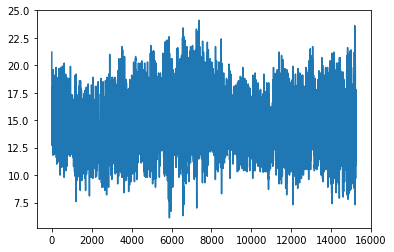

In [83]:
# Gráficas
#x1=range(len(dataSolarRangoSD))
x2 = range(len(datosSD))
#plt.plot(x1,dataSolarRangoSD['AirTemp'])
plt.plot(x2,datosSD['Temp - °C'])
plt.show()

In [ ]:
plt.plot(x1,dataSolarRangoSD['AirTemp'])
plt.show()

In [ ]:
plt.plot(x2,datosSD['Temp - °C'])
plt.show()
"""falta machear las horas"""

In [16]:
# Fecha mínima y máxima
min_date = cantidad_totales.min()#datosSD["Date & Time"].min()
max_date = cantidad_totales.max()#datosSD["Date & Time"].max()

# Todas las fechas entre 'min_date' y 'max_date'
all_dates = cantidad_totales#pd.date_range(start = min_date, end = max_date, freq="H")

# Fijar la fecha como el índice
#datosSD = datosSD.set_index("Date & Time")

# Rellenar fechas faltantes
datosSDConFechas = datosSD.reindex(all_dates, fill_value=np.nan)

# Regresar fecha como columna
datosSDConFechas = datosSDConFechas.reset_index().rename(columns={"index":"Date & Time"})

# Nueva tabla
print("Nuevo tamaño {}".format(datosSDConFechas.shape))

Nuevo tamaño (15258, 31)


In [ ]:
datosSD.shape

In [ ]:
min_date

In [ ]:
max_date

In [ ]:
all_dates

In [ ]:
datosSDConFechas

In [ ]:
"""Haré un dataset para tenerlos en el mismo y luego hacer drop de los NaN"""
# Se dividen los datos
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

"""#Tengo que poner empatar por fechas"""
dataX = dataSolarRangoSD.select_dtypes(include=numerics)
dataX


In [17]:
datosSDConFechas.index

RangeIndex(start=0, stop=15258, step=1)

In [18]:
datosSD.index

RangeIndex(start=0, stop=15253, step=1)

In [ ]:
dataY = datosSDConFechas.select_dtypes(include=numerics)
dataY = dataY.set_index(all_dates)
dataY

In [ ]:
len(dataX)==len(dataY)

In [ ]:
print(" Datos X (datos SolCast): "+str(len(dataX))+", Datos Y (datos SD): "+str(len(dataY)))

In [98]:
X_train

,AirTemp,Ghi,WindSpeed10m,Date & Time
4511,15.3,217.0,1.3,2019-11-11 15:00:00
3334,16.8,380.0,1.5,2019-09-23 14:00:00
8547,11.2,0.0,2.0,2020-04-27 20:00:00
10027,13.8,509.0,1.1,2020-06-28 12:00:00
7842,19.9,1016.0,1.9,2020-03-29 11:00:00
...,...,...,...,...
5269,8.5,0.0,1.0,2019-12-13 05:00:00
13641,8.7,1.0,0.8,2020-11-26 05:00:00
5468,18.4,457.0,2.3,2019-12-21 12:00:00
881,14.8,274.0,1.0,2019-06-13 09:00:00


## Visualización previa

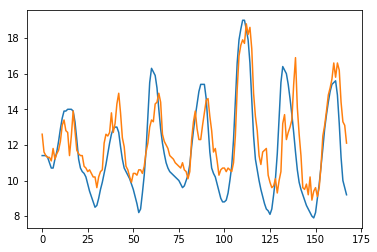

In [26]:
# Comparar temperaturas
datos_merge = datosSD.merge(datos_solar[['Date & Time',"AirTemp"]],how="left", on='Date & Time')

k = 2358

start = k + 0
end = k + 24*7

graph = datos_merge.iloc[start:end,:]

plt.plot(graph["AirTemp"].tolist())
plt.plot(graph['Temp - °C'].tolist())

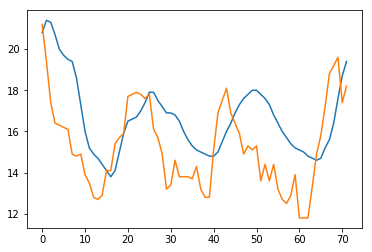

In [59]:
x1 = datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"].head(72)["AirTemp"].tolist()
x2 = datosSD.head(72)['Temp - °C'].tolist()

plt.plot(x1)
plt.plot(x2)

In [85]:
len(datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"])

15103

In [86]:
len(datosSD)

15253

In [87]:
len(datos_solar)

123334

In [90]:
"Faltan 150"
datosSD.iloc[0]

Date & Time                        2019-05-07 16:00:00
Date                               2019-05-07 00:00:00
Time                                          16:00:00
Temp - °C                                         21.2
Temp. Alta - °C                                   21.3
Temp. Baja - °C                                   21.2
Hum - %                                             47
Punto de rocío - °C                                9.5
Wet Bulb - °C                                     12.2
Velocidad del viento - m/s                         0.9
Dirección del viento                               ENE
Viento Corriente - m                              0.89
Alta velocidad del viento - m/s                    1.8
Alta Dirección del viento                          ESE
Viento Frío - °C                                  21.2
Índice de calor - °C                              20.2
THW Index - °C                                    20.2
THSW  índice - °C                                  NaN
Barómetro 

In [93]:
datos_solcast_SD = datos_solar[datos_solar["PeriodStart"]>="2019-05-07T16:00:00Z"]

In [95]:
datos_solcast_SD.iloc[0]

PeriodEnd            2019-05-07T17:00:00Z
PeriodStart          2019-05-07T16:00:00Z
Period                              PT60M
AirTemp                              20.8
AlbedoDaily                          0.12
Azimuth                               -22
CloudOpacity                         20.8
DewpointTemp                         15.5
Dhi                                   459
Dni                                   396
Ebh                                   384
Ghi                                   843
GtiFixedTilt                          792
GtiTracking                           806
PrecipitableWater                    27.4
RelativeHumidity                     71.6
SurfacePressure                     815.6
WindDirection10m                      137
WindSpeed10m                          2.7
Zenith                                 14
Date & Time           2019-05-07 11:00:00
Name: 108231, dtype: object

In [96]:
datos_merge.iloc[0]

AirTemp                             19.7
AlbedoDaily                         0.12
Azimuth                               74
CloudOpacity                        34.4
DewpointTemp                        16.5
Dhi                                  185
Dni                                  107
Ebh                                   39
Ghi                                  224
GtiFixedTilt                         217
GtiTracking                          303
PrecipitableWater                   28.8
RelativeHumidity                    81.8
SurfacePressure                    813.4
WindDirection10m                     138
WindSpeed10m                         2.1
Zenith                                69
Date & Time          2019-05-07 16:00:00
Temp - °C                           21.2
Name: 0, dtype: object

## Modelos Temperatura

In [21]:
import sklearn
from sklearn.metrics import *


def myMetrics(true, pred):
    r2 = r2_score(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    #mape = sklearn.metrics.mean_absolute_percentage_error(true, pred)
    mae = sklearn.metrics.mean_absolute_error(true, pred)
    #maxerror = sklearn.metrics.max_error()
    mbe = np.mean(pred-true)
    
    print('RMSE: '+str(rmse)) #Root Mean Square error
    print('MAE: '+ str(mae)) #Mean Absolute  error
    print('MBE: '+ str(mbe)) #Mean Bias error
    print('R2: '+str(r2))
    #print('MAPE: '+ str(mape)) #Mean Absolute percentage error
   # print('Max Error'+str(maxerror))

In [66]:
sinNan = datos_merge.dropna()
myMetrics(sinNan["AirTemp"], sinNan['Temp - °C'])

RMSE: 2.285487727701249
R2: 0.5272626705521904
MBE: 1.2339217139392302
MAE: 1.9359496058748233


In [22]:
def RegresionYgraficas(modelo, predictores = ["AirTemp",'Ghi', 'WindSpeed10m'], variable_y = "Temp - °C"):
    
    predictores.append('Date & Time')

    # Comparar temperaturas
    datos_merge = datosSD.merge(datos_solar[predictores], how="left", on='Date & Time')

    all_columns = predictores.copy()
    all_columns.append(variable_y)

    datos_merge = datos_merge[all_columns]

    label_data = datos_merge.dropna()
    predictores.remove('Date & Time')

    X = label_data[predictores]
    y = label_data[variable_y]

    # Separar en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Modelo
    modelo.fit(X_train, y_train)
    y_predict = modelo.predict(X_test)

    # Errores
    rmse = math.sqrt(mean_squared_error(y_test, y_predict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test, y_predict)
    print("MAE:", mae)
    
    mbe = np.mean( y_predict - y_test )
    print('MBE: '+ str(mbe)) #Mean Bias error

    r2 = r2_score(y_test, y_predict) 
    print("R2:", r2)

    x=range(len(y_test))

    # Gráficas
    plt.plot(x[:100], y_test[:100])
    plt.plot(x[:100], y_predict[:100])
    plt.show()

### Regresión Lineal

RMSE: 1.5033965469382127
MAE: 1.2033066027915231
R2: 0.6735143678957047


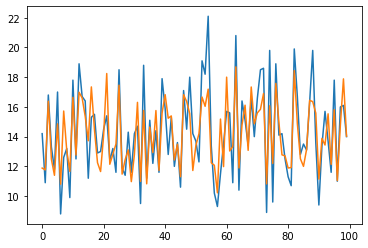

In [139]:
# Regresión Lineal - Pocos predictores
model_lr = linear_model.LinearRegression()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
RegresionYgraficas(model_lr, predictores=predictores)

RMSE: 1.2704892384194544
MAE: 1.002875571576043
R2: 0.7668373630152882


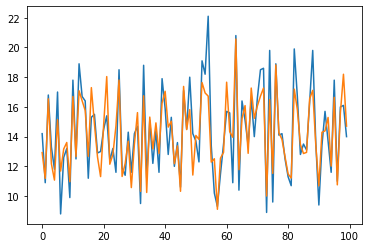

In [140]:
# Regresión Lineal - Todos los predictores
model_lr_todo = linear_model.LinearRegression()
predictores = list(datos_solar.select_dtypes(include=numerics).columns)
RegresionYgraficas(model_lr_todo, predictores=predictores)

### Random Forest

RMSE: 1.431054357770699
MAE: 1.1179269707765103
R2: 0.7041788385242405


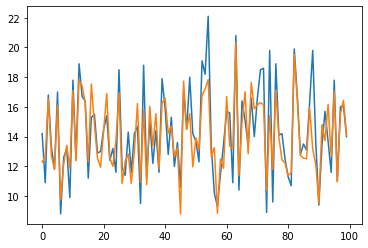

In [141]:
# Regresión Lineal - Todos los predictores
model_rf = RandomForestRegressor()
predictores = predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
RegresionYgraficas(model_rf, predictores=predictores)

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.0920757008911646
MAE: 0.8388245200404177
R2: 0.8277249181672144


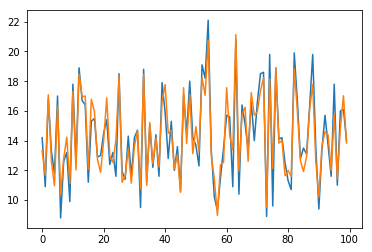

In [27]:
# Regresión Lineal - Todos los predictores
model_rf_todo = RandomForestRegressor()
predictores = list(datos_solar.select_dtypes(include=numerics).columns)
RegresionYgraficas(model_rf_todo, predictores=predictores)

### XGBoost

RMSE: 1.3877205686297447
MAE: 1.0871107849218744
R2: 0.7218231226397138


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


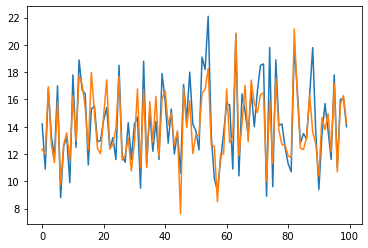

In [143]:
# Regresión Lineal - Todos los predictores
model_xgboost = xgboost.XGBRegressor()
predictores = ["AirTemp",'Ghi', 'WindSpeed10m']
RegresionYgraficas(model_xgboost, predictores = predictores)

In [28]:
# Regresión Lineal - Todos los predictores
model_xgboost_todo = xgboost.XGBRegressor()
predictores = list(datos_solar.select_dtypes(include = numerics).columns)
RegresionYgraficas(model_xgboost_todo, predictores = predictores)

NameError: name 'xgboost' is not defined

In [ ]:

dataY = shuffle_data["Temp - °C"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

C:\Users\Sony\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1.1057534705449017
MAE: 0.8561266419669923
R2: 0.8233825544638442


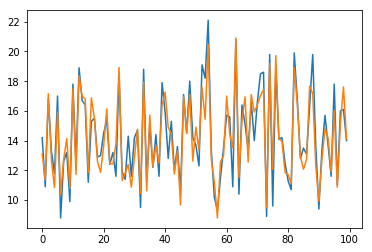

'Ya tengo resultados parciales de temperatura usando los mismos datos sin completar (CDT)'

In [31]:
# Se dividen los datos

#shuffle_data = datosSD.sample(frac=1)
#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp - °C")
model_rf_todo = RandomForestRegressor()

predictores = list(datos_solar.select_dtypes(include=numerics).columns)
predictores.append('Date & Time')

variable_y = "Temp - °C"

# Comparar temperaturas
datos_merge = datosSD.merge(datos_solar[predictores], how="left", on='Date & Time')

all_columns = predictores.copy()
all_columns.append(variable_y)

datos_merge = datos_merge[all_columns]

label_data = datos_merge.dropna()
predictores.remove('Date & Time')

X = label_data[predictores]
y = label_data[variable_y]

# Separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Modelo
model_rf_todo.fit(X_train, y_train)
y_predict = model_rf_todo.predict(X_test)

# Errores
rmse = math.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_predict)
print("MAE:", mae)

r2 = r2_score(y_test, y_predict) 
print("R2:", r2)

x=range(len(y_test))

# Gráficas
plt.plot(x[:100], y_test[:100])
plt.plot(x[:100], y_predict[:100])
plt.show()
"""Ya tengo resultados parciales de temperatura usando los mismos datos sin completar (CDT)"""

In [34]:
"Tengo que adaptar/predecir todos los datos satelitales a los datos en sitio con el modelo que ya tengo"
datosSolar_completos = pd.read_csv("datosSOLCAST_Unidos.csv")
datos_adaptados = model_rf_todo.predict(datosSolar_completos[predictores])

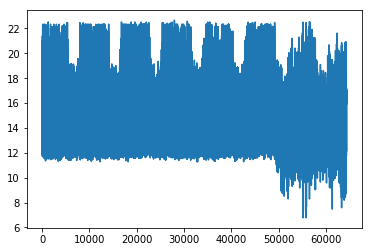

In [40]:
plt.plot(datos_adaptados[59000:])

In [41]:
datos_adaptados.to_csv("TempSD_adaptada.csv", index=False, encoding="latin-1")
"Falta predecir velocidad de viento e irradiancia"

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [64]:
datos_merge #= datosSD.merge(datos_solar[predictores], how="left", on='Date & Time')

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,Date & Time,Temp - °C
0,19.7,0.12,74.0,34.4,16.5,185.0,107.0,39.0,224.0,217.0,303.0,28.8,81.8,813.4,138.0,2.1,69.0,2019-05-07 16:00:00,21.2
1,19.5,0.12,74.0,26.5,17.1,55.0,64.0,9.0,64.0,62.0,78.0,28.7,86.1,813.9,139.0,2.1,83.0,2019-05-07 17:00:00,19.4
2,19.4,0.12,72.0,29.1,17.8,0.0,0.0,0.0,0.0,0.0,0.0,28.5,90.5,814.3,140.0,2.1,98.0,2019-05-07 18:00:00,17.4
3,18.6,0.12,70.0,28.0,17.6,0.0,0.0,0.0,0.0,0.0,0.0,28.5,93.6,814.8,139.0,2.1,112.0,2019-05-07 19:00:00,16.4
4,17.3,0.12,66.0,39.3,16.5,0.0,0.0,0.0,0.0,0.0,0.0,28.7,95.3,815.4,138.0,2.1,126.0,2019-05-07 20:00:00,16.3
5,16.0,0.12,58.0,35.9,15.5,0.0,0.0,0.0,0.0,0.0,0.0,28.9,97.0,815.9,136.0,2.1,139.0,2019-05-07 21:00:00,16.2
6,15.2,0.12,42.0,0.3,14.9,0.0,0.0,0.0,0.0,0.0,0.0,28.8,98.1,816.0,138.0,1.8,150.0,2019-05-07 22:00:00,16.1
7,14.9,0.12,14.0,0.0,14.7,0.0,0.0,0.0,0.0,0.0,0.0,28.4,98.7,815.7,148.0,1.2,158.0,2019-05-07 23:00:00,14.9
8,14.7,0.12,-23.0,0.8,14.5,0.0,0.0,0.0,0.0,0.0,0.0,27.9,99.2,815.3,174.0,0.8,156.0,2019-05-08 00:00:00,14.8
9,14.4,0.12,-47.0,23.5,14.3,0.0,0.0,0.0,0.0,0.0,0.0,27.6,99.6,814.9,203.0,0.6,148.0,2019-05-08 01:00:00,14.9


## Modelos Velocidad de viento

## Modelos Radiación

## Normalizando

In [ ]:
''' Esto lo había hecho antes para los datos del SD viejos, Re hacer'''

from sklearn import preprocessing

x = shuffle_data.select_dtypes(include=numerics).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_shuffle_data = pd.DataFrame(x_scaled, columns = shuffle_data.select_dtypes(include=numerics).columns)
normalized_shuffle_data

In [ ]:
# Se dividen los datos
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#dataX = normalized_shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_data[["AirTemp"]]
dataY = normalized_shuffle_data["Temp"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

In [ ]:
# Modelo
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x=range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [ ]:
coeficientes = list(zip(dataX.columns, clf.coef_))
sorted(coeficientes, key=lambda x: -abs(x[1]))

## Con datos de Enel (wetransfer)

Fecha mínima 2019-01-30 06:00:00
Fecha máxima 2021-02-11 00:00:00

In [69]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

datos_Enel_numeric = datos_Enel.select_dtypes(include=numerics)

shuffle_datos_Enel_numeric = datos_Enel_numeric.sample(frac=1)

shuffle_datos_Enel_numeric = shuffle_datos_Enel_numeric.dropna()

shuffle_datos_Enel_numeric.head()

,Temp - °C,Temp. Alta - °C,Temp. Baja - °C,Hum - %,Punto de rocío - °C,Wet Bulb - °C,Velocidad del viento - m/s,Viento Corriente - m,Alta velocidad del viento - m/s,Viento Frío - °C,...,Tasa de lluvia - mm/h,Rad Solar - W/m^2,Energía solar,Rad Solar Alta - W/m^2,ET - mm,El índice UV - Index,Dosis de UV,Alto índice UV - Index,Días-grado de calentamiento,Días-grado de enfriamiento
Date & Time,,,,,,,,,,,,,,,,,,,,,
2020-12-29 13:00:00,18.9,20.7,18.9,63.0,11.7,13.6,0.9,0.89,4.9,18.9,...,0.0,211.0,18.16,345.0,0.20,3.7,1.59,10.9,0.000,0.025
2020-07-24 18:00:00,15.5,16.0,15.4,69.0,9.8,11.5,2.2,2.24,5.4,15.5,...,0.0,45.0,3.87,118.0,0.05,0.0,0.00,0.0,0.118,0.000
2020-02-19 03:00:00,14.9,15.2,14.4,70.0,9.5,11.1,0.4,0.45,2.2,14.9,...,0.0,0.0,0.00,0.0,0.03,0.0,0.00,0.0,0.141,0.000
2019-09-11 08:00:00,15.3,15.3,12.6,68.0,9.4,11.1,0.9,0.89,4.5,15.3,...,0.0,224.0,19.27,348.0,0.13,1.2,0.51,2.3,0.127,0.000
2020-10-04 03:00:00,12.1,12.5,11.8,88.0,10.1,10.8,0.9,0.89,2.7,12.1,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.262,0.000


In [70]:
list(datos_Enel)

['Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [71]:
shuffle_datos_Enel_numeric.shape

(15002, 25)

In [72]:
#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_datos_Enel_numeric.drop(columns='Temp - °C')
dataY = shuffle_datos_Enel_numeric['Temp - °C']

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

RMSE: 0.031200153732737965
MAE: 0.0144908514881165
R2: 0.9998593271608162


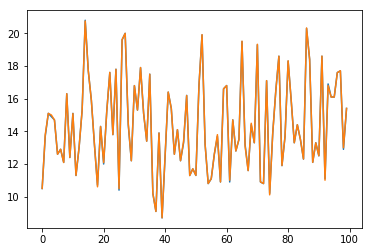

In [73]:
# Modelo
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x = range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [74]:
coeficientes = list(zip(dataX.columns, clf.coef_))
sorted(coeficientes, key=lambda x: -abs(x[1]))

[('Índice de calor - °C', 0.9744161422582798),
 ('Viento Frío - °C', 0.9184740608590207),
 ('THW Index - °C', -0.9041748254686227),
 ('Días-grado de enfriamiento', 0.029591475260149908),
 ('Viento Corriente - m', 0.025042486314319802),
 ('Velocidad del viento - m/s', -0.018142538266856537),
 ('Días-grado de calentamiento', -0.016337385435675505),
 ('ET - mm', 0.01357937762509808),
 ('Wet Bulb - °C', 0.01311345558013278),
 ('Dosis de UV', 0.012715306798083924),
 ('Energía solar', -0.007550443808129459),
 ('Punto de rocío - °C', -0.006658707262929673),
 ('El índice UV - Index', -0.004327066532403481),
 ('Temp. Baja - °C', 0.002471883804264427),
 ('Hum - %', -0.002372438470465241),
 ('Barómetro - mm Hg', 0.0012468551424631316),
 ('Alto índice UV - Index', -0.0009319856411582676),
 ('Rad Solar - W/m^2', 0.000652857318365298),
 ('THSW  índice - °C', 0.0005377794426662917),
 ('Alta velocidad del viento - m/s', -0.0005170430594506059),
 ('Temp.\xa0Alta - °C', 0.0002735273409813512),
 ('Lluvia

In sitio 2019-2020

satelitales para completar los datos in sitio

Tenemos varios modelos para la temperatura, este es el que mejor da, revisar el overfitting

## Se prueba omitiendo los ceros entre las 6pm y 6am

In [75]:
# Se prueba omitiendo los ceros entre las 6pm y 6am
dataX = dataX[datosSDSinCompletar.RadSolar!=0]
dataY = datosSDSinCompletar.RadSolar[datosSDSinCompletar.RadSolar!=0]

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

# Modelo de regresión lineal
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Cálculos de errores
rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

# Se grafica
x=range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredict)
plt.show()

NameError: name 'datosSDSinCompletar' is not defined

## Se prueba con las 3 irradiaciones

In [ ]:
# solo DHI, DNI y GHI de SolarCast
dataX= pd.DataFrame({'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY= datosSDSinCompletar.RadSolar

# Se dividen los datos
train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

# Se crea y ajusta el modelo de regresión
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Se calculan los errores
rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

# Se grafica
x=range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredict)
plt.show()

In [ ]:
# Se corrigen los ceros
correccionZeros = yPredict[testY==0]
copiaYPredict = yPredict
copiaYPredict[testY==0]=0

# Se recalculan los errores
rmse = math.sqrt(mean_squared_error(testY,copiaYPredict))
print(rmse)

r2 = r2_score(testY,copiaYPredict) 
print(r2)

# Se grafica
x=range(len(testY))
plt.plot(x, testY)
plt.plot(x, copiaYPredict)
plt.show()

# Random Forest Regressor
## Se prueba con todos los datos disponibles

In [ ]:
dataXTodo = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_data[["AirTemp"]]
dataY = shuffle_data["Temp"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredictTodo)
print("MAE:", mae)

r2 = r2_score(testY, yPredictTodo) 
print("R2:", r2)

x=range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredictTodo)
plt.show()

In [ ]:
dataXTodo = shuffle_wetransfer_numeric.drop(columns='Temp - °C')
dataX = shuffle_wetransfer_numeric[["Temp - °C"]]
dataY = shuffle_wetransfer_numeric['Temp - °C']

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredictTodo)
print("MAE:", mae)

r2 = r2_score(testY, yPredictTodo) 
print("R2:", r2)

x=range(len(testY))
plt.plot(x[:24*7], testY[:24*7])
plt.plot(x[:24*7], yPredictTodo[:24*7])
plt.xticks(np.arange(0, 24*7, step=24),["L","M","X","J","V","S","D"])
plt.show()

In [ ]:
# Se 
#dataXTodo= pd.DataFrame({'Temp':datosSDSinCompletar.Temp, 'VelocidadViento':datosSDSinCompletar.VelocidadViento, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
#dataY= datosSDSinCompletar.RadSolar

dataXTodo = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_data[["AirTemp"]]
dataY = shuffle_data["Temp"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainXTodo, testXTodo = dataXTodo[0:train_size], dataXTodo[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rfTodo = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfTodo.fit(trainXTodo, trainY)

yPredictTodo = model_rfTodo.predict(testXTodo)

rmse = math.sqrt(mean_squared_error(testY,yPredictTodo))
print(rmse)

r2 = r2_score(testY, yPredictTodo) 
print(r2)

x=range(len(testY))
plt.plot(x, testY)
plt.plot(x, yPredictTodo)
plt.show()

#%% Más grafiquitas
x=range(len(datosSolarSinCompletar.WindSpeed10m[24*7*2:24*7*3]))
plt.plot(x, datosSolarSinCompletar.WindSpeed10m[24*7*2:24*7*3])
plt.plot(x, datosSDSinCompletar.VelocidadViento[24*7*2:24*7*3])
plt.show()
#%%
x=range(len(testY[24*7*2:24*7*3]))
plt.plot(x, testY[24*7*2:24*7*3])
plt.plot(x, yPredict[24*7*2:24*7*3])
plt.show()
#%%
x=range(len(dataX[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, dataX.Ghi[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, dataY[test_size+24*7*3:test_size+24*7*4])
plt.show()

#%%
rmse = math.sqrt(mean_squared_error(datosSDSinCompletar.RadSolar,datosSolarSinCompletar.Ghi))
print(rmse)
r2 = r2_score(datosSDSinCompletar.RadSolar,datosSolarSinCompletar.Ghi) 
print(r2)
#%%
rmse = math.sqrt(mean_squared_error(datosSolarSinCompletar.WindSpeed10m,datosSDSinCompletar.VelocidadViento))
print('rMSE velocidad viento:'+str(rmse))
r2 = r2_score(datosSDSinCompletar.VelocidadViento, datosSolarSinCompletar.WindSpeed10m) 
print('r2 velocidad viento:'+str(r2))
rmse = math.sqrt(mean_squared_error(datosSDSinCompletar.Temp, datosSolarSinCompletar.AirTemp))
print('rMSE temperatura'+ str(rmse))
r2 = r2_score( datosSDSinCompletar.Temp, datosSolarSinCompletar.AirTemp) 
print('r2 temperatura'+ str(r2))
#%%
x=range(len(datosSolarSinCompletar.AirTemp[24*7*2:24*7*3]))
plt.plot(x, datosSolarSinCompletar.AirTemp[24*7*2:24*7*3])
plt.plot(x, datosSDSinCompletar.Temp[24*7*2:24*7*3])
plt.show()

In [ ]:
#%%
dataX= pd.DataFrame({'AirTemp': datosSolarSinCompletar.AirTemp, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY= datosSDSinCompletar.RadSolar

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]
model_rf = RandomForestRegressor(n_estimators=100,  min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf.fit(trainX, trainY)

yPredictTrain = model_rf.predict(trainX)
yPredictTest = model_rf.predict(testX)

rmseTrain = math.sqrt(mean_squared_error(trainY,yPredictTrain))
rmseTest = math.sqrt(mean_squared_error(testY,yPredictTest))
print('RMSE Train: '+str(rmseTrain))
print('RMSE Test: '+str(rmseTest))

r2Train = r2_score(trainY,yPredictTrain) 
r2Test = r2_score(testY,yPredictTest) 
print('r2 Train: '+str(r2Train))
print('r2 Test: '+str(r2Test))

In [ ]:
#%%
dataX= pd.DataFrame({'SurfacePressure':datosSolarSinCompletar.SurfacePressure,'RelativeHumidity':datosSolarSinCompletar.RelativeHumidity,'CloudOpacity': datosSolarSinCompletar.CloudOpacity, 'WindSpeed10m': datosSolarSinCompletar.WindSpeed10m, 'AirTemp':datosSolarSinCompletar.AirTemp, 'Dhi':datosSolarSinCompletar.Dhi, 'Dni':datosSolarSinCompletar.Dni, 'Ghi':datosSolarSinCompletar.Ghi})
dataY= datosSDSinCompletar.RadSolar

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf = RandomForestRegressor(n_estimators=100, max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf.fit(trainX, trainY)

yPredictTrain = model_rf.predict(trainX)
yPredictTest = model_rf.predict(testX)

rmseTrain = math.sqrt(mean_squared_error(trainY,yPredictTrain))
rmseTest = math.sqrt(mean_squared_error(testY,yPredictTest))
print('RMSE Train: '+str(rmseTrain))
print('RMSE Test: '+str(rmseTest))

r2Train = r2_score(trainY,yPredictTrain) 
r2Test = r2_score(testY,yPredictTest) 
print('r2 Train: '+str(r2Train))
print('r2 Test: '+str(r2Test))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictTest[test_size+24*7*3:test_size+24*7*4])
plt.show()

In [ ]:
#%%
# LINEAR REGRESION
#%%
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredict[test_size+24*7*3:test_size+24*7*4])
plt.show()

rmse = math.sqrt(mean_squared_error(testY,yPredict))
print(rmse)

r2 = r2_score(testY,yPredict) 
print(r2)

In [ ]:
#%% 
# GRIDSEARCH CV

from sklearn.model_selection import GridSearchCV
estimator = RandomForestRegressor()
param_grid = {"n_estimators": [10,50,100,200], "max_features": ["auto", "sqrt", "log2"],"min_samples_split" : [2,4,8],"bootstrap": [True, False]}
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
grid.fit(trainX, trainY)
print(grid.best_score_)
print(grid.best_params_)

#%%
x=range(len(dataX[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, dataX.Ghi[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, dataY[test_size+24*7*3:test_size+24*7*4])
plt.show()

# Modelos de predicción de temperatura de celda

# Ecuaciones

## Paper 2

In [49]:
def ross(Ta, Tnoct, Gt):
    Tc = Ta + (Tnoct - 20)/800*Gt
    return Tc


## Paper 3

In [50]:
def risser(G, Ta, Vw):
    Tc = 3.81 + 0.0282*G + 1.31*Ta - 1.65*Vw
    return Tc

In [51]:
alfa = 0.0138
beta = 0.031
gamma = 0.042

In [52]:
def servant(Ta, G, Vw, nm):
    Tc = Ta + alfa*G*(1+beta*Ta)*(1-gamma*Vw)*(1-1.053*nm)
    return Tc

In [53]:
def duffie(Ta, G, Gnoct, Vw, Tcnoct, Tanoct, n):
    Tc = Ta + ((G/Gnoct)*(9.5/(5.7+3.8*Vw)*(Tcnoct-Tanoct)*(1-nc/(r*a))))

Se calculan R2, RMSE, MBE

In [54]:
import sklearn
from sklearn.metrics import *


def myMetrics(true, pred):
    r2 = r2_score(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    #mape = sklearn.metrics.mean_absolute_percentage_error(true, pred)
    mae = sklearn.metrics.mean_absolute_error(true, pred)
    #maxerror = sklearn.metrics.max_error()
    mbe = np.mean(pred-true)
    
    print('RMSE: '+str(rmse)) #Root Mean Square error
    print('R2: '+str(r2))
    print('MBE: '+ str(mbe)) #Mean Bias error
    print('MAE: '+ str(mae)) #Mean Absolute  error
    #print('MAPE: '+ str(mape)) #Mean Absolute percentage error
   # print('Max Error'+str(maxerror))

In [55]:
list(dataX)

['AlbedoDaily',
 'Azimuth',
 'CloudOpacity',
 'DewpointTemp',
 'Dhi',
 'Dni',
 'Ebh',
 'Ghi',
 'GtiFixedTilt',
 'GtiTracking',
 'PrecipitableWater',
 'RelativeHumidity',
 'SurfacePressure',
 'WindDirection10m',
 'WindSpeed10m',
 'Zenith']

In [56]:
list(datosSD)

['Date & Time',
 'Date',
 'Time',
 'Temp - °C',
 'Temp.\xa0Alta - °C',
 'Temp. Baja - °C',
 'Hum - %',
 'Punto de rocío - °C',
 'Wet Bulb - °C',
 'Velocidad del viento - m/s',
 'Dirección del viento',
 'Viento Corriente - m',
 'Alta velocidad del viento - m/s',
 'Alta Dirección del viento',
 'Viento Frío - °C',
 'Índice de calor - °C',
 'THW Index - °C',
 'THSW  índice - °C',
 'Barómetro - mm Hg',
 'Lluvia - mm',
 'Tasa de lluvia - mm/h',
 'Rad Solar - W/m^2',
 'Energía solar',
 'Rad Solar Alta - W/m^2',
 'ET - mm',
 'El índice UV - Index',
 'Dosis de UV',
 'Alto índice UV - Index',
 'Días-grado de calentamiento',
 'Días-grado de enfriamiento']

In [57]:
#Datos Satelitales
Ta = dataX['AirTemp']
Tnoct = 25
G = dataX[ 'Ghi']
Vw = dataX['WindSpeed10m']
#nm

yRoss = ross(Ta, Tnoct, G)
yRisser = risser(G, Ta, Vw)
#yServant = servant(Ta, G, Vw, nm)

KeyError: 'AirTemp'

In [ ]:
myMetrics(yRoss, yRisser)

In [ ]:
# Gráficas
x1=range(len(yRoss))
x2=range(len(yRisser))
plt.plot(x1,yRoss)
plt.plot(x2,yRisser)
plt.show()

In [ ]:
plt.plot(x1,yRoss)
plt.show()

In [ ]:
# Datos en sitio 
"""Los datos del SD no tienen la temperatura de los paneles"""
Ta = dataX['AirTemp']
Tnoct = 25
G = dataX[ 'Ghi']
Vw = dataX['WindSpeed10m']
#nm

yRoss = ross(Ta, Tnoct, G)
yRisser = risser(G, Ta, Vw)

## Modelos Propios

In [ ]:

# Función para graficar predicciones
def RegresionYgraficasSG(variable_x = ["AirTemp"], variable_y = "Temp"):

    # Se dividen los datos
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    #dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
    dataX = shuffle_data[variable_x]
    dataY = shuffle_data["Temp"]

    train_size = int(len(dataX)*0.8)
    test_size = len(dataX) - train_size

    trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
    trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

    # Modelo
    clf = linear_model.LinearRegression()
    clf.fit(trainX, trainY)
    yPredict = clf.predict(testX)

    # Errores
    rmse = math.sqrt(mean_squared_error(testY, yPredict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(testY, yPredict)
    print("MAE:", mae)

    r2 = r2_score(testY,yPredict) 
    print("R2:", r2)

    x = range(len(testY))

    # Gráficas
    plt.plot(x[:100], testY[:100])
    plt.plot(x[:100], yPredict[:100])
    plt.show()

In [ ]:
# Función para graficar predicciones
def ModeloYgraficas(model, variable_x = ["AirTemp"], variable_y = "Temp"):

    # Se dividen los datos
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    #dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
    dataX = shuffle_data[variable_x]
    dataY = shuffle_data["Temp"]

    train_size = int(len(dataX)*0.8)
    test_size = len(dataX) - train_size

    trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
    trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

    # Modelo
    model.fit(trainX, trainY)
    yPredict = clf.predict(testX)

    # Errores
    rmse = math.sqrt(mean_squared_error(testY, yPredict))
    print("RMSE:", rmse)

    mae = mean_absolute_error(testY, yPredict)
    print("MAE:", mae)

    r2 = r2_score(testY,yPredict) 
    print("R2:", r2)

    x = range(len(testY))

    # Gráficas
    plt.plot(x[:100], testY[:100])
    plt.plot(x[:100], yPredict[:100])
    plt.show()

## Datos ENEL

Datos in sitio:
    ENEL side adaptation (NREL) check
    SD temp promedio horas pasadas, velocidad de viento (interpolación)
    Side-adaptation con los datos [SOLCAST SD nuevos]
    
Calcular modelos de temperatura

In [ ]:
# Datos ENEL
ruta = os.getcwd()+"\\Data\\Datos_ENEL_TemperaturaSD\\METEO\\"
datosEnel = pd.read_csv(ruta+'meteost.csv')
datosEnel.head()

In [ ]:
# Datos ENELPyra
datosEnelPyra = pd.read_csv(ruta+'pyranometers.csv')
datosTempModuleEnel = pd.read_excel(os.getcwd()+"\\Data\\TEMP MODULE-2.xlsx", header=1)
datosEnelPyra.head()

In [ ]:
datosTempModuleEnel.head()

In [ ]:
datosTempModuleEnel.iloc[0]

In [ ]:
datosTempModuleEnel.iloc[-1]

In [ ]:
# Arreglar columnas numéricas
test = datosTempModuleEnel.replace("0  FA", np.nan)
test = test.replace("FA", "", regex=True)
test = test.replace(",", ".", regex=True)

# Strip all columns
strip_columns = list(test.columns)
strip_columns.remove("Time")
test[strip_columns] = test[strip_columns].astype(str).apply(lambda x: x.str.strip()).astype(float)
   
test.head()

In [ ]:
test.isna().sum()

In [ ]:
test.describe()

In [ ]:
datosTempModuleEnel['Time'].min()

In [ ]:
fechasEnel = pd.date_range(start = datosTempModuleEnel['Time'].min(), end = datosTempModuleEnel['Time'].max(), freq="H" )
fechasEnel

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nuevo = test.iloc[0:59]#.dropna().select_dtypes(include=numerics).mean(axis=0)
nuevo
#ya que no la logré para el dataset completo haré una sola columna

In [ ]:
datosTempModuleEnel['EP1_I06_AN00037'].iloc[0:59].mean()

In [ ]:
"""sacar el promedio con o group by o un for de modulo 60"""

nuevo = [datosTempModuleEnel['EP1_I06_AN00037'].iloc[0:59].mean()]

for i in range(1,len(datosTempModuleEnel)-1,60):
    #nuevo[i%60] = datosTempModuleEnel[i:i+59].mean()
    temp = datosTempModuleEnel['EP1_I06_AN00037'].iloc[i:i+59].mean()
    print(temp)
    """print(i)
    print(i+59)
    print(temp)"""    
    nuevo.append(temp)
    

In [ ]:
range(1,len(datosTempModuleEnel)-1,60)

In [ ]:
print(nuevo)

In [ ]:
len(nuevo)

In [ ]:
type(datosTempModuleEnel['Time'][0])

In [ ]:
test['Time2'] = datosTempModuleEnel['Time'].apply(lambda x: x.replace(minute=0, second=0))

In [ ]:
test.dtypes


In [ ]:
"Toca quitarles las FA"


In [ ]:
a = test['EP1_I06_AN00037'].astype(float).groupby('Time2').mean()
print(a)

In [ ]:
datosTempSD = pd.read_csv('Temp_SD_2019_01_01_2021_04_28.csv', sep=";")#,error_bad_lines=False)
datosTempSD.columns = ["Time", "Tc", "Ta"]
datosTempSD["Tc"] = datosTempSD["Tc"].str.replace(",",".").astype(float)
datosTempSD["Ta"] = datosTempSD["Ta"].str.replace(",",".").astype(float)

datosTempSD = datosTempSD[(~datosTempSD["Tc"].isna())].reset_index(drop=True)

"""
Acá vamos
"""

datosTempSD.head()

In [ ]:
datosTempSD.loc[8758]["Tm"]

In [ ]:
from csv import reader

# open file in read mode
with open('Temp_SD_2019_01_01_2021_04_28.csv', 'r') as read_obj:
    
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for idx,row in enumerate(csv_reader):
        # row variable is a list that represents a row in csv
        print(row)
        if idx == 3:
            break

In [ ]:
datosTempSD.head()

# Otros

In [ ]:
# Modelo datos SD 2020
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x=range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

In [42]:
# Modelo datos SD 2021
clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredict = clf.predict(testX)

# Errores
rmse = math.sqrt(mean_squared_error(testY, yPredict))
print("RMSE:", rmse)

mae = mean_absolute_error(testY, yPredict)
print("MAE:", mae)

r2 = r2_score(testY,yPredict) 
print("R2:", r2)

x=range(len(testY))

# Gráficas
plt.plot(x[:100], testY[:100])
plt.plot(x[:100], yPredict[:100])
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Se guardan los datos
data.to_csv("datos_procesados.csv", index=False, encoding="latin-1")

In [ ]:
"""jupyter nbextension enable toc
pip install writeandexecute
import "https://raw.githubusercontent.com/minrk/ipython_extensions/master/extensions/writeandexecute.py"
jlpm run watch"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Se cargan los datos

In [ ]:
ruta = os.getcwd()+"\\data\\"
# ruta = drive
#Datos viejos del SD
datosSD2020 = pd.read_excel(ruta+"datosRadiacionSD.xlsx")
datosfechaSD2020 = datosSD2020.set_index('DateTime')

In [ ]:
a =[None]*2
fechitas=['2006-12-31T20:00:00Z','2006-12-31T21:00:00Z','2006-12-31T22:00:00Z','2006-12-31T23:00:00Z','2007-01-01T00:00:00Z']
a.append(pd.Series(fechitas))
b = datosSolar.PeriodStart[0:len(datosSolar)-5]
a.append(b)
c=pd.concat(a)
dataFechaSolarCastArreglado = datosSolar.set_index(c)

In [ ]:
# Datos SD viejos
datosSDSinCompletar = datosfechaSD2020.loc['2019-05-07 17:00:00':'2019-05-12  1:00:00']
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-12 9:00:00':'2019-05-16  3:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-16 11:00:00':'2019-05-29  6:00:00'])
datosSDSinCompletar = datosSDSinCompletar.append(datosfechaSD2020.loc['2019-05-29 14:00:00':'2019-07-8  9:00:00'])

In [ ]:
#
datosSolarSinCompletar = dataFechaSolarCastArreglado.loc['2019-05-07T17:00:00Z':'2019-05-12T01:00:00Z']
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-12T09:00:00Z':'2019-05-16T03:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-16T11:00:00Z':'2019-05-29T06:00:00Z'])
datosSolarSinCompletar = datosSolarSinCompletar.append(dataFechaSolarCastArreglado.loc['2019-05-29T14:00:00Z':'2019-07-08T09:00:00Z'])
#
datosSolarSinCompletar2020 = datosSolarSinCompletar.set_index(datosSDSinCompletar.index)

In [ ]:
datosSDSinCompletar2020

In [ ]:
datosSolarSinCompletar

In [ ]:
# Merge data
data = datosSDSinCompletar2020.merge(datosSolarSinCompletar2020, left_index=True, right_index=True)
shuffle_data = data.sample(frac=1)
shuffle_data

In [ ]:
shuffle_data = datosSD.sample(frac=1)

# Se dividen los datos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#dataX = shuffle_data.select_dtypes(include=numerics).drop(columns="Temp")
dataX = shuffle_data[["AirTemp"]]
dataY = shuffle_data["Temp"]

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX, testX = dataX[0:train_size], dataX[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

In [ ]:
#%% Sofía está muy cansada y llegó hasta aquí
datosPredecir1 = datosfechaSD.loc['2019-05-12 2:00:00':'2019-05-12 8:00:00']
datosPredecir2 = datosfechaSD.loc['2019-05-16  4:00:00':'2019-05-16 10:00:00']
datosPredecir3 = datosfechaSD.loc['2019-05-29  7:00:00':'2019-05-29 13:00:00']
datosPredecir = datosPredecir1
datosPredecir = datosPredecir.append(datosPredecir2)
datosPredecir = datosPredecir.append(datosPredecir3)

datosPredecirSolar1 =  dataFechaSolarCastArreglado.loc['2019-05-12T02:00:00Z':'2019-05-12T08:00:00Z']
datosPredecirSolar2 = dataFechaSolarCastArreglado.loc['2019-05-16T04:00:00Z':'2019-05-16T10:00:00Z']
datosPredecirSolar3 = dataFechaSolarCastArreglado.loc['2019-05-29T07:00:00Z':'2019-05-29T13:00:00Z']
#%%
datosPredecirSolar = datosPredecirSolar1
datosPredecirSolar = datosPredecirSolar.append(datosPredecirSolar2)
datosPredecirSolar = datosPredecirSolar.append(datosPredecirSolar3)
#%%
datosPredecirSolar1 = datosPredecirSolar1.set_index(datosPredecir1.index)
datosPredecirSolar2 = datosPredecirSolar2.set_index(datosPredecir2.index)
datosPredecirSolar3 = datosPredecirSolar3.set_index(datosPredecir3.index)

#%% falla porque no hay los datos en sitio
dataXTodo = pd.DataFrame({'Temp':datosPredecir.Temp, 'VelocidadViento':datosPredecir.VelocidadViento, 'Dhi':datosPredecirSolar.Dhi, 'Dni':datosPredecirSolar.Dni, 'Ghi':datosPredecirSolar.Ghi})
yPredictTodo = model_rfTodo.predict(dataXTodo) 
#%%
dataX1 = pd.DataFrame({'SurfacePressure':datosPredecirSolar1.SurfacePressure,'RelativeHumidity':datosPredecirSolar1.RelativeHumidity,'CloudOpacity': datosPredecirSolar1.CloudOpacity, 'WindSpeed10m': datosPredecirSolar1.WindSpeed10m, 'AirTemp':datosPredecirSolar1.AirTemp, 'Dhi':datosPredecirSolar1.Dhi, 'Dni':datosPredecirSolar1.Dni, 'Ghi':datosPredecirSolar1.Ghi})
dataX2 = pd.DataFrame({'SurfacePressure':datosPredecirSolar2.SurfacePressure,'RelativeHumidity':datosPredecirSolar2.RelativeHumidity,'CloudOpacity': datosPredecirSolar2.CloudOpacity, 'WindSpeed10m': datosPredecirSolar2.WindSpeed10m, 'AirTemp':datosPredecirSolar2.AirTemp, 'Dhi':datosPredecirSolar2.Dhi, 'Dni':datosPredecirSolar2.Dni, 'Ghi':datosPredecirSolar2.Ghi})
dataX3 = pd.DataFrame({'SurfacePressure':datosPredecirSolar3.SurfacePressure,'RelativeHumidity':datosPredecirSolar3.RelativeHumidity,'CloudOpacity': datosPredecirSolar3.CloudOpacity, 'WindSpeed10m': datosPredecirSolar3.WindSpeed10m, 'AirTemp':datosPredecirSolar3.AirTemp, 'Dhi':datosPredecirSolar3.Dhi, 'Dni':datosPredecirSolar3.Dni, 'Ghi':datosPredecirSolar3.Ghi})

yPredict1 = model_rf.predict(dataX1)
yPredict2 = model_rf.predict(dataX2)
yPredict3 = model_rf.predict(dataX3)
#%%

x=range(len(yPredict))
plt.plot(x,datosPredecirSolar.Ghi)
plt.plot(x,yPredict)
#%%
datosCompletos = np.concatenate((np.array(datosfechaSD.loc['2019-05-07 17:00:00':'2019-05-12  1:00:00'].RadSolar),
                                yPredict1,
                                np.array(datosfechaSD.loc['2019-05-12 9:00:00':'2019-05-16  3:00:00'].RadSolar),
                                yPredict2,
                                np.array(datosfechaSD.loc['2019-05-16 11:00:00':'2019-05-29  6:00:00'].RadSolar),
                                yPredict3,
                                np.array(datosfechaSD.loc['2019-05-29 14:00:00':'2019-07-8  9:00:00'].RadSolar)))
#%%
datosCompletosDF = pd.DataFrame({'DateTime':datosSD.DateTime[1:len(datosSD)], 'Radiacion':datosCompletos})
datosCompletosDF.to_csv('DatosSDCompletados.csv', header=True, index=False)
#%%
datosIDEAMAuto = pd.read_csv('datosIDEAMAuto.csv')
completo = pd.read_csv('../Tesis/DatosKioskoNSRDB/DatosUnidosMediaHoraConBisiestos.csv')
#%%
fechasNSRDB= completo.Year.astype(int).astype(str)+'-'+completo.Month.astype(int).astype(str)+'-'+completo.Day.astype(int).astype(str)+'T'+completo.Hour.astype(int).astype(str)+':00:00Z'
completo = completo.set_index(fechasNSRDB)
#%%
prueba = datetime(int(completo.Year[0]), int(completo.Month[0]), int(completo.Day[0]) , int(completo.Hour[0]), 00 )
print(prueba)
#%%
prueba2 = datetime.strptime(datosIDEAMAuto.Fecha[0], '%Y-%m-%d %H:%M')
print(prueba2)
#%%
datosCompatiblesNRELeIDEAMAuto =  completo.loc['2013-12-1T0:00:00Z':'2018-10-1T0:00:00Z']

#%%
dataXIDEAMAuto = []
dataYIDEAMAuto = []
dataPredecirIDEAMAuto = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMAuto)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMAuto.Year[i]), int(datosCompatiblesNRELeIDEAMAuto.Month[i]), int(datosCompatiblesNRELeIDEAMAuto.Day[i]) , int(datosCompatiblesNRELeIDEAMAuto.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMAuto.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataXIDEAMAuto.append(datosCompatiblesNRELeIDEAMAuto.iloc[i])
        dataYIDEAMAuto.append(datosIDEAMAuto.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecirIDEAMAuto.append(datosCompatiblesNRELeIDEAMAuto.iloc[i])
        i = i+1
dataXIDEAMAuto = pd.DataFrame(dataXIDEAMAuto)
dataPredecirIDEAMAuto = pd.DataFrame(dataPredecirIDEAMAuto)   
#%% 
r2 = r2_score(dataYIDEAMAuto, dataXIDEAMAuto.GHI)
#%%
dataXfeaturesIDEAMAuto = pd.DataFrame({'DHI':dataXIDEAMAuto.DHI,'DNI':dataXIDEAMAuto.DNI, 'GHI':dataXIDEAMAuto.GHI})

train_sizeIDEAMAuto = int(len(dataXfeaturesIDEAMAuto)*0.8)
test_sizeIDEAMAuto = len(dataXfeaturesIDEAMAuto) - train_sizeIDEAMAuto

trainXIDEAMAuto, testXIDEAMAuto = dataXfeaturesIDEAMAuto[0:train_sizeIDEAMAuto], dataXfeaturesIDEAMAuto[test_sizeIDEAMAuto:len(dataXIDEAMAuto)]
trainYIDEAMAuto, testYIDEAMAuto = dataYIDEAMAuto[0:train_sizeIDEAMAuto], dataYIDEAMAuto[test_sizeIDEAMAuto:len(dataYIDEAMAuto)]

model_rfIDEAMAuto = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rfIDEAMAuto.fit(trainXIDEAMAuto, trainYIDEAMAuto)

yPredictIDEAMAuto = model_rfIDEAMAuto.predict(testXIDEAMAuto)

rmseIDEAMAuto = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictIDEAMAuto))
print(rmseIDEAMAuto)

r2IDEAMAuto = r2_score(testYIDEAMAuto,yPredictIDEAMAuto) 
print(r2)

xIDEAMAuto=range(len(testYIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictIDEAMAuto[test_size+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()

#%%
dataXfeatures1IDEAMAuto = pd.DataFrame({'DHI':dataXIDEAMAuto.DHI,'DNI':dataXIDEAMAuto.DNI, 'GHI':dataXIDEAMAuto.GHI, 'Clearsky DHI':dataXIDEAMAuto['Clearsky DHI'],'Clearsky DNI':dataXIDEAMAuto['Clearsky DNI'],'Clearsky GHI':dataXIDEAMAuto['Clearsky GHI'], 'Temperature':dataXIDEAMAuto.Temperature,'Wind Speed':dataXIDEAMAuto['Wind Speed'], 'Cloud Type':dataXIDEAMAuto['Cloud Type'], 'Relative Humidity':dataXIDEAMAuto['Relative Humidity'], 'Precipitable Water':dataXIDEAMAuto['Precipitable Water']})

train_sizeIDEAMAuto = int(len(dataXIDEAMAuto)*0.8)
test_sizeIDEAMAuto = len(dataXIDEAMAuto) - train_sizeIDEAMAuto

trainX1IDEAMAuto, testX1IDEAMAuto = dataXfeatures1IDEAMAuto[0:train_sizeIDEAMAuto], dataXfeatures1IDEAMAuto[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)]
trainYIDEAMAuto, testYIDEAMAuto = dataYIDEAMAuto[0:train_sizeIDEAMAuto], dataYIDEAMAuto[test_sizeIDEAMAuto:len(dataYIDEAMAuto)]

model_rf1IDEAMAuto = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1IDEAMAuto.fit(trainX1IDEAMAuto, trainYIDEAMAuto)
yPredictRandomForestIDEAMAuto = model_rf1IDEAMAuto.predict(testX1IDEAMAuto)
rmseRandomForest = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictRandomForestIDEAMAuto))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testYIDEAMAuto,yPredictRandomForestIDEAMAuto) 
print('r2RandomForest: '+str(r2RandomForest))
xIDEAMAuto = range(len(testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictRandomForestIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1IDEAMAuto, trainYIDEAMAuto)
yPredictRegresionLinealIDEAMAuto = clf.predict(testX1IDEAMAuto)
rmseRegresionLineal = math.sqrt(mean_squared_error(testYIDEAMAuto,yPredictRegresionLinealIDEAMAuto))
print('rmseRegresionLineal: '+str(rmseRegresionLineal

#%% scores TRAIN
yPredictRandomForestIDEAMAutoTrain = model_rf1IDEAMAuto.predict(trainX1IDEAMAuto)
rmseRandomForestTrain = math.sqrt(mean_squared_error(trainYIDEAMAuto,yPredictRandomForestIDEAMAutoTrain))
print('rmseRandomForest: '+str(rmseRandomForestTrain))
r2RandomForestTrain = r2_score(trainYIDEAMAuto,yPredictRandomForestIDEAMAutoTrain) 
print('r2RandomForest: '+str(r2RandomForestTrain))
))
r2RegresionLineal = r2_score(testYIDEAMAuto,yPredictRegresionLinealIDEAMAuto) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

xIDEAMAuto = range(len(testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4]))
plt.plot(xIDEAMAuto, testYIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.plot(xIDEAMAuto, yPredictRegresionLinealIDEAMAuto[test_sizeIDEAMAuto+24*7*3:test_sizeIDEAMAuto+24*7*4])
plt.show()
#%%
casiCompletos = model_rf1IDEAMAuto.predict(dataXfeatures1IDEAMAuto)
rmseRandomForestCC = math.sqrt(mean_squared_error(dataYIDEAMAuto,casiCompletos))
print('rmseRandomForest: '+str(rmseRandomForestCC))
r2RandomForestCC = r2_score(dataYIDEAMAuto,casiCompletos) 
print('r2RandomForest: '+str(r2RandomForestCC))

#%%
dataXfeatures2IDEAMAuto = pd.DataFrame({'DHI':completo.DHI,'DNI':completo.DNI, 'GHI':completo.GHI, 'Clearsky DHI':completo['Clearsky DHI'],'Clearsky DNI':completo['Clearsky DNI'],'Clearsky GHI':completo['Clearsky GHI'], 'Temperature':completo.Temperature,'Wind Speed':completo['Wind Speed'], 'Cloud Type':completo['Cloud Type'], 'Relative Humidity':completo['Relative Humidity'], 'Precipitable Water':completo['Precipitable Water']})
NRELAuto = model_rf1IDEAMAuto.predict(dataXfeatures2IDEAMAuto)

#%%
copiaNRELAuto = NRELAuto
copiaNRELAuto[(completo.Hour<6)|(completo.Hour>18)]=0

#%%
datosIDEAMCompletadosDF =pd.DataFrame({'Year':completo.Year, 'Month':completo.Month, 'Day': completo.Day, 'Hour':completo.Hour, 'Valor':copiaNRELAuto})
datosIDEAMCompletadosDF.to_csv('datosNREL2IDEAMAuto.csv', header=True, index=False)

#%%
copiaYPredictRandomForest=yPredictRandomForestIDEAMAuto
copiaYPredictRandomForest[(dataXIDEAMAuto[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)].Hour<6)|(dataXIDEAMAuto.Hour[test_sizeIDEAMAuto:len(dataXfeatures1IDEAMAuto)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testYIDEAMAuto,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testYIDEAMAuto,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))

#%%
a= dataX.GHI[dataX.GHI==0]
y =np.array(dataY)
c = y==0
a == c

#%%
yPredictRandomForestIDEAMAuto[testY==0]

#%% 
dataPredecirFeaturesIDEAMAuto = pd.DataFrame({'DHI':dataPredecirIDEAMAuto.DHI,'DNI':dataPredecirIDEAMAuto.DNI, 'GHI':dataPredecirIDEAMAuto.GHI, 'Clearsky DHI':dataPredecirIDEAMAuto['Clearsky DHI'],'Clearsky DNI':dataPredecirIDEAMAuto['Clearsky DNI'],'Clearsky GHI':dataPredecirIDEAMAuto['Clearsky GHI'], 'Temperature':dataPredecirIDEAMAuto.Temperature,'Wind Speed':dataPredecirIDEAMAuto['Wind Speed'], 'Cloud Type':dataPredecirIDEAMAuto['Cloud Type'], 'Relative Humidity':dataPredecirIDEAMAuto['Relative Humidity'], 'Precipitable Water':dataPredecirIDEAMAuto['Precipitable Water']})
datosPredichos = model_rf1IDEAMAuto.predict(dataPredecirFeaturesIDEAMAuto)

#%% Correción ceros
datosCompatiblesNRELeIDEAMAuto[datosCompatiblesNRELeIDEAMAuto.GHI==0]

#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMAuto)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMAuto.Year[i]), int(datosCompatiblesNRELeIDEAMAuto.Month[i]), int(datosCompatiblesNRELeIDEAMAuto.Day[i]) , int(datosCompatiblesNRELeIDEAMAuto.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMAuto.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMAuto.Valor[j])
        i = i+1
        j = j+1
    else:
        if((datosCompatiblesNRELeIDEAMAuto.Hour[i]<5)|(datosCompatiblesNRELeIDEAMAuto.Hour[i]>19)):
            datosIDEAMCompletados.append(0)
        else:
            datosIDEAMCompletados.append(datosPredichos[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMAuto.Year, 'Month':datosCompatiblesNRELeIDEAMAuto.Month, 'Day': datosCompatiblesNRELeIDEAMAuto.Day, 'Hour':datosCompatiblesNRELeIDEAMAuto.Hour, 'Valor':datosIDEAMCompletados})

#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMAutoCompletados.csv', header=True, index=False)
#%%
completo2 = pd.read_csv('../Tesis/DatosKioskoNSRDB/DatosUnidosPromediados.csv')
dataPredecir = pd.DataFrame({'DHI':completo2.DHI,'DNI':completo2.DNI, 'GHI':completo2.GHI, 'Clearsky DHI':completo2['Clearsky DHI'],'Clearsky DNI':completo2['Clearsky DNI'],'Clearsky GHI':completo2['Clearsky GHI'], 'Temperature':completo2.Temperature,'Wind Speed':completo2['Wind Speed'], 'Cloud Type':completo2['Cloud Type'], 'Relative Humidity':completo2['Relative Humidity'], 'Precipitable Water':completo2['Precipitable Water']})
datosPredichos = model_rf1IDEAMAuto.predict(dataPredecir)
datosPredichos.to_csv('datosIDEAMAutoCompletados.csv', header=True, index=False)

#%% Correción ceros
datosCompatiblesNRELeIDEAMAuto[datosCompatiblesNRELeIDEAMAuto.GHI==0]
#%%
'''
'''
datosIDEAMNuevaGeneracion = pd.read_csv('datosIDEAMNuevaGeneracion.csv') 
datosCompatiblesNRELeIDEAMNuevaGeneracion =  completo.loc['2015-2-1T0:00:00Z':'2018-10-1T0:00:00Z']
#%%
dataX = []
dataY = []
dataPredecir = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMNuevaGeneracion)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Year[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Month[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Day[i]) , int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMNuevaGeneracion.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataX.append(datosCompatiblesNRELeIDEAMNuevaGeneracion.iloc[i])
        dataY.append(datosIDEAMNuevaGeneracion.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecir.append(datosCompatiblesNRELeIDEAMNuevaGeneracion.iloc[i])
        i = i+1
dataX = pd.DataFrame(dataX)
dataPredecir = pd.DataFrame(dataPredecir)   
#%%
dataXfeatures = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI})

train_size = int(len(dataXfeatures)*0.8)
test_size = len(dataXfeatures) - train_size

trainX, testX = dataXfeatures[0:train_size], dataXfeatures[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX, trainY)
yPredictRandomForest = model_rf1.predict(testX)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredictRegresionLineal = clf.predict(testX)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
dataXfeatures1 = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI, 'Clearsky DHI':dataX['Clearsky DHI'],'Clearsky DNI':dataX['Clearsky DNI'],'Clearsky GHI':dataX['Clearsky GHI'], 'Temperature':dataX.Temperature,'Wind Speed':dataX['Wind Speed'], 'Cloud Type':dataX['Cloud Type'], 'Relative Humidity':dataX['Relative Humidity'], 'Precipitable Water':dataX['Precipitable Water']})

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX1, testX1 = dataXfeatures1[0:train_size], dataXfeatures1[test_size:len(dataXfeatures1)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX1, trainY)
yPredictRandomForest = model_rf1.predict(testX1)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1, trainY)
yPredictRegresionLineal = clf.predict(testX1)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()

#%%
copiaYPredictRandomForest=yPredictRandomForest
copiaYPredictRandomForest[(dataX[test_size:len(dataXfeatures1)].Hour<6)|(dataX.Hour[test_size:len(dataXfeatures1)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testY,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testY,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))

#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMNuevaGeneracion)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Year[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Month[i]), int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Day[i]) , int(datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMNuevaGeneracion.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMNuevaGeneracion.Valor[j])
        i = i+1
        j = j+1
    else:
        datosIDEAMCompletados.append(copiaYPredictRandomForest[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMNuevaGeneracion.Year, 'Month':datosCompatiblesNRELeIDEAMNuevaGeneracion.Month, 'Day': datosCompatiblesNRELeIDEAMNuevaGeneracion.Day, 'Hour':datosCompatiblesNRELeIDEAMNuevaGeneracion.Hour, 'Valor':datosIDEAMCompletados})
#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMNuevaGeneracionCompletados.csv', header=True, index=False)
#%%
#%%
'''
'''
datosIDEAMVillaTeresa = pd.read_csv('datosIDEAMVillaTeresa.csv') 
#%%
datosCompatiblesNRELeIDEAMVillaTeresa =  completo.loc['2007-5-10T12:00:00Z':'2016-9-30T23:00:00Z']
#%%
dataX = []
dataY = []
dataPredecir = []
i = 0
j = 0
while (i < len(datosCompatiblesNRELeIDEAMVillaTeresa)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMVillaTeresa.Year[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Month[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Day[i]) , int(datosCompatiblesNRELeIDEAMVillaTeresa.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMVillaTeresa.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        dataX.append(datosCompatiblesNRELeIDEAMVillaTeresa.iloc[i])
        dataY.append(datosIDEAMVillaTeresa.Valor[j])
        i = i+1
        j = j+1
    else:
        dataPredecir.append(datosCompatiblesNRELeIDEAMVillaTeresa.iloc[i])
        i = i+1
dataX = pd.DataFrame(dataX)
dataPredecir = pd.DataFrame(dataPredecir)   
#%%
dataXfeatures = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI})

train_size = int(len(dataXfeatures)*0.8)
test_size = len(dataXfeatures) - train_size

trainX, testX = dataXfeatures[0:train_size], dataXfeatures[test_size:len(dataX)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX, trainY)
yPredictRandomForest = model_rf1.predict(testX)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX, trainY)
yPredictRegresionLineal = clf.predict(testX)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
dataXfeatures1 = pd.DataFrame({'DHI':dataX.DHI,'DNI':dataX.DNI, 'GHI':dataX.GHI, 'Clearsky DHI':dataX['Clearsky DHI'],'Clearsky DNI':dataX['Clearsky DNI'],'Clearsky GHI':dataX['Clearsky GHI'], 'Temperature':dataX.Temperature,'Wind Speed':dataX['Wind Speed'], 'Cloud Type':dataX['Cloud Type'], 'Relative Humidity':dataX['Relative Humidity'], 'Precipitable Water':dataX['Precipitable Water']})

train_size = int(len(dataX)*0.8)
test_size = len(dataX) - train_size

trainX1, testX1 = dataXfeatures1[0:train_size], dataXfeatures1[test_size:len(dataXfeatures1)]
trainY, testY = dataY[0:train_size], dataY[test_size:len(dataY)]

model_rf1 = RandomForestRegressor(n_estimators=100,max_features=4, min_samples_leaf=10,random_state=0, n_jobs=2)
model_rf1.fit(trainX1, trainY)
yPredictRandomForest = model_rf1.predict(testX1)
rmseRandomForest = math.sqrt(mean_squared_error(testY,yPredictRandomForest))
print('rmseRandomForest: '+str(rmseRandomForest))
r2RandomForest = r2_score(testY,yPredictRandomForest) 
print('r2RandomForest: '+str(r2RandomForest))
x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRandomForest[test_size+24*7*3:test_size+24*7*4])
plt.show()

clf = linear_model.LinearRegression()
clf.fit(trainX1, trainY)
yPredictRegresionLineal = clf.predict(testX1)
rmseRegresionLineal = math.sqrt(mean_squared_error(testY,yPredictRegresionLineal))
print('rmseRegresionLineal: '+str(rmseRegresionLineal))
r2RegresionLineal = r2_score(testY,yPredictRegresionLineal) 
print('r2RegresionLineal: '+str(r2RegresionLineal))

x=range(len(testY[test_size+24*7*3:test_size+24*7*4]))
plt.plot(x, testY[test_size+24*7*3:test_size+24*7*4])
plt.plot(x, yPredictRegresionLineal[test_size+24*7*3:test_size+24*7*4])
plt.show()
#%%
copiaYPredictRandomForest=yPredictRandomForest
copiaYPredictRandomForest[(dataX[test_size:len(dataXfeatures1)].Hour<6)|(dataX.Hour[test_size:len(dataXfeatures1)]>18)]=0
rmseconCeros = math.sqrt(mean_squared_error(testY,copiaYPredictRandomForest))
print('rmseRegresionLineal: '+str(rmseconCeros))
r2conCeros = r2_score(testY,copiaYPredictRandomForest)
print('r2conCeros: '+str(r2conCeros))
#%%
datosIDEAMCompletados = []
i = 0
j = 0
k = 0
while (i < len(datosCompatiblesNRELeIDEAMVillaTeresa)):
    fechaNREL = datetime(int(datosCompatiblesNRELeIDEAMVillaTeresa.Year[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Month[i]), int(datosCompatiblesNRELeIDEAMVillaTeresa.Day[i]) , int(datosCompatiblesNRELeIDEAMVillaTeresa.Hour[i]), 00 )
    fechaIDEAM = datetime.strptime(datosIDEAMVillaTeresa.Fecha[j], '%Y-%m-%d %H:%M')
    if(fechaNREL == fechaIDEAM):
        datosIDEAMCompletados.append(datosIDEAMVillaTeresa.Valor[j])
        i = i+1
        j = j+1
    else:
        datosIDEAMCompletados.append(copiaYPredictRandomForest[k])
        k = k+1
        i=i+1
datosIDEAMCompletadosDF =pd.DataFrame({'Year':datosCompatiblesNRELeIDEAMVillaTeresa.Year, 'Month':datosCompatiblesNRELeIDEAMVillaTeresa.Month, 'Day': datosCompatiblesNRELeIDEAMVillaTeresa.Day, 'Hour':datosCompatiblesNRELeIDEAMVillaTeresa.Hour, 'Valor':datosIDEAMCompletados})
#%%
datosIDEAMCompletadosDF.to_csv('datosIDEAMVillaTeresaCompletados.csv', header=True, index=False)